In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')

%matplotlib inline
# TODO
# One hot encoding
# hash encoding
# preprocessing

## Exploring the data

In [5]:

df = pd.DataFrame(pd.read_csv('data_for_student_case.csv'))
df.bookingdate = pd.to_datetime(df.bookingdate)
df.creationdate = pd.to_datetime(df.creationdate)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290382 entries, 0 to 290381
Data columns (total 17 columns):
txid                            290382 non-null int64
bookingdate                     290382 non-null datetime64[ns]
issuercountrycode               289889 non-null object
txvariantcode                   290382 non-null object
bin                             290242 non-null float64
amount                          290382 non-null float64
currencycode                    290382 non-null object
shoppercountrycode              289900 non-null object
shopperinteraction              290382 non-null object
simple_journal                  290382 non-null object
cardverificationcodesupplied    275665 non-null object
cvcresponsecode                 290382 non-null int64
creationdate                    290382 non-null datetime64[ns]
accountcode                     290382 non-null object
mail_id                         290382 non-null object
ip_id                           290382 non-null 

In [6]:
df.bookingdate.unique()

array(['2015-11-09T14:26:51.000000000', '2015-11-09T14:27:38.000000000',
       '2015-11-23T16:34:16.000000000', ...,
       '2015-10-31T22:03:39.000000000', '2015-11-02T20:16:57.000000000',
       '2015-11-03T18:57:01.000000000'], dtype='datetime64[ns]')

In [7]:
for col in df.columns:
    print(f'Column: {col}')
    print(df[col].unique())
    print(f'length: {len(df[col])}')

Column: txid
[     1      2      3 ... 482732 482733 482734]
length: 290382
Column: bookingdate
['2015-11-09T14:26:51.000000000' '2015-11-09T14:27:38.000000000'
 '2015-11-23T16:34:16.000000000' ... '2015-10-31T22:03:39.000000000'
 '2015-11-02T20:16:57.000000000' '2015-11-03T18:57:01.000000000']
length: 290382
Column: issuercountrycode
['MX' 'US' nan 'BR' 'CA' 'ES' 'CH' 'SA' 'TH' 'SG' 'NL' 'GB' 'IN' 'TW' 'MY'
 'DO' 'CO' 'CL' 'UA' 'AU' 'BE' 'TZ' 'PH' 'IT' 'DE' 'HU' 'KZ' 'GR' 'KE'
 'IL' 'VN' 'NO' 'AR' 'CN' 'HN' 'EG' 'AE' 'BB' 'FR' 'ID' 'BA' 'FI' 'PE'
 'RU' 'HK' 'KR' 'NZ' 'TR' 'IE' 'PK' 'SE' 'RO' 'EC' 'UY' 'BS' 'BH' 'PA'
 'BO' 'DK' 'AZ' 'QA' 'BZ' 'MT' 'LB' 'VE' 'JP' 'SV' 'LK' 'ZA' 'CK' 'LA'
 'KH' 'AT' 'MO' 'FJ' 'RS' 'LU' 'SB' 'JO' 'ZM' 'AO' 'PL' 'NG' 'LT' 'IQ'
 'BG' 'PT' 'GE' 'GI' 'LV' 'KW' 'BM' 'OM' 'CY' 'SK' 'ZZ' 'AL' 'GH' 'MU'
 'MD' 'SL' 'CR' 'BN' 'LY' 'ZW' 'SI' 'IS' 'BY' 'TJ' 'BW' 'MK' 'HR' 'VG'
 'BD' 'EE' 'CW' 'AM' 'AI' 'MN' 'PY' 'TM' 'ME' 'AD' 'GT' 'PR' 'DZ' 'TT'
 'CZ' 'KY' 'CG' 'CM'

In [8]:
print(df.simple_journal.value_counts())
print(df.cvcresponsecode.value_counts())
print(df.accountcode.value_counts())
print(df.txvariantcode.value_counts())

Settled       236691
Refused        53346
Chargeback       345
Name: simple_journal, dtype: int64
1    207568
0     76231
2      4072
3      2481
5        30
Name: cvcresponsecode, dtype: int64
UKAccount        207413
APACAccount       30733
MexicoAccount     27904
SwedenAccount     24332
Name: accountcode, dtype: int64
visadebit         172592
mccredit           63717
mcdebit            16679
visaclassic        16306
visaplatinum       10125
visagold            6545
visa                2019
visabusiness        1030
visasignature        619
visacorporate        421
mc                   167
visapurchasing       122
electron              27
vpay                   7
cirrus                 6
Name: txvariantcode, dtype: int64


In [9]:
txgroup = df.groupby(by=['txvariantcode'])
tx_avg = txgroup.mean()
tx_count = txgroup.count()
tx_count

,txid,bookingdate,issuercountrycode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
txvariantcode,,,,,,,,,,,,,,,,
cirrus,6,6,6,6,6,6,6,6,6,4,6,6,6,6,6,6
electron,27,27,25,27,27,27,27,27,27,27,27,27,27,27,27,27
mc,167,167,0,167,167,167,167,167,167,165,167,167,167,167,167,167
mccredit,63717,63717,63717,63678,63717,63717,63585,63717,63717,60261,63717,63717,63717,63717,63717,63717
mcdebit,16679,16679,16679,16671,16679,16679,16663,16679,16679,16235,16679,16679,16679,16679,16679,16679
visa,2019,2019,1696,2018,2019,2019,2015,2019,2019,1891,2019,2019,2019,2019,2019,2019
visabusiness,1030,1030,1030,1030,1030,1030,1009,1030,1030,1022,1030,1030,1030,1030,1030,1030
visaclassic,16306,16306,16306,16303,16306,16306,16282,16306,16306,15984,16306,16306,16306,16306,16306,16306
visacorporate,421,421,421,421,421,421,421,421,421,409,421,421,421,421,421,421


In [10]:
txgroup.simple_journal


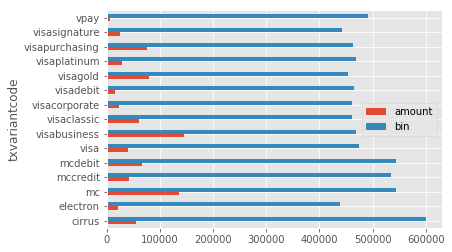

In [11]:
tx_series = tx_count.iloc[:,0]

features_of_interest = pd.DataFrame({'amount': tx_avg['amount'], 'bin': tx_avg['bin']})

features_of_interest.plot(kind='barh')

### Preprocessing 
1 remove Refused transactions
2 add amount_converted column with GBP amount

In [12]:
# First remove the refused transactions
df = df[df['simple_journal'] != 'Refused']

# Now we add a column to all the data containing the transacted amount in GBP. 
def convert_currency(row):
    coversion_dict = {'SEK':0.08766,'MXN':0.04057,'AUD':0.5715,'NZD':0.5327,'GBP':1}
    currency = row['currencycode']
    amount = row['amount']
    return round(amount * coversion_dict[currency])

df['amount_convert'] = df.apply(lambda x: convert_currency(x), axis=1)
df.head()

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,amount_convert
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,2629
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,1822
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,6081
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,4459
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,3647


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


mean: 
#is_fraud
False     18888.996037
True     105137.652174
Name: amount, dtype: float64

std: 
#is_fraud
False     41342.000541
True     124188.477258
Name: amount, dtype: float64

max amount: 
#is_fraud
False    1955765.0
True      769500.0
Name: amount, dtype: float64



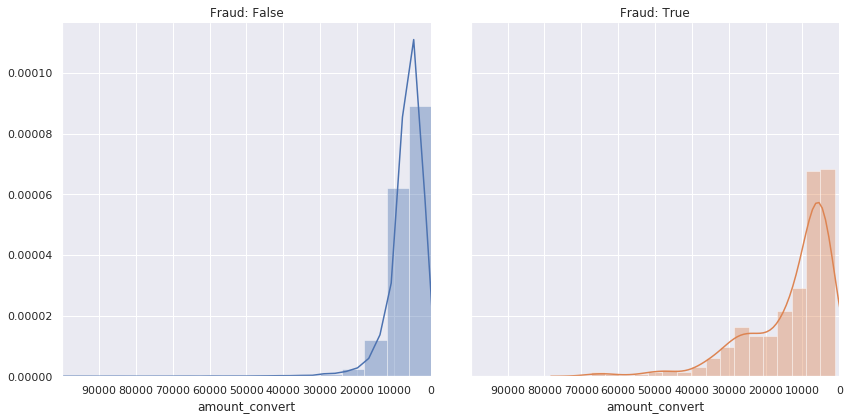

In [13]:
## Visualize fraud vs amounts
df['is_fraud'] = df['simple_journal'].apply(lambda x: x=='Chargeback')

import seaborn as sns
sns.set(color_codes=True)
g = sns.FacetGrid(df, col="is_fraud", size=6,hue='is_fraud', sharex=True, xlim=100000)
g.map(sns.distplot,"amount_convert", kde=True)
g.set(xticks=range(0,100000, 10000))
g.set_titles('Fraud: {col_name}')

print(f"mean: \n#{df.groupby(by=['is_fraud'])['amount'].mean()}\n")
print(f"std: \n#{df.groupby(by=['is_fraud'])['amount'].std()}\n")
print(f"max amount: \n#{df.groupby(by=['is_fraud'])['amount'].max()}\n")

Form the plots above we can see that the transacted amount for fraud transactions is higher on average than the non fraud ones, and also contain more outliers for the higher amounts.

Looking at the numerical values of the mean and deviation the transacted amounts we see confirmation that the mean amount of fraudulent transactions is much higher than non-fraudulent ones, mainly caused by large outliers.


/usr/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


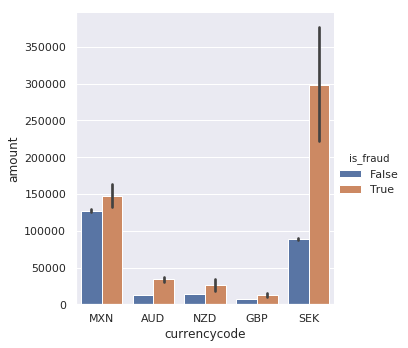

In [14]:

sns.factorplot(data=df, kind='bar', x="currencycode", y="amount", hue="is_fraud")


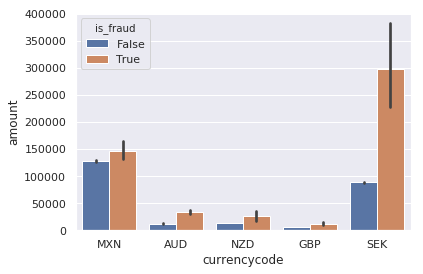

In [21]:
# Bar plot of fraud vs legit 
sns.barplot(data=df, x="currencycode", y="amount", hue="is_fraud")


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  after removing the cwd from sys.path.


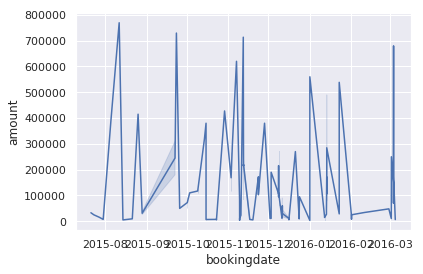

In [22]:
# Amount of fraud over time shows a small decline in the amount of fraud committed over time.
fraudulent = df[df["is_fraud"] == 1]
len(fraudulent)
sns.lineplot(x="bookingdate", y="amount", data=fraudulent.sort_index(by='bookingdate'))
# fm_daily = df.groupby(pd.TimeGrouper('D'))


In [ ]:
# Attempting to explore is theres a higher chance of fraud when issuercountrycode != shoppercountrycode

len(df['issuercountrycode'])
len(df['shoppercountrycode'])
len(df[df['issuercountrycode'] != df['shoppercountrycode']])
is_equal = df[df['issuercountrycode'] == df['shoppercountrycode']]
not_equal = df[df['issuercountrycode'] != df['shoppercountrycode']]
# sns.barplot(data=is_equal, x="currencycode", y="amount", hue="is_fraud")
# sns.barplot(data=df, x="currencycode", y="amount", hue="is_fraud")
len(is_equal[is_equal['is_fraud'] == True])
# is_equal['is_fraud']
# fig1, ax1 = plt.subplots()
# ax1.pie(is_equal['is_fraud'], labels=['is fraud', 'is not fraud'], autopct='%1.1f%%', shadow=True)
# ax1.axis('equal')
# plt.show()
df.plot(kind='pie', y='amount')

